In [2]:
# IMPORTS
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve
)

import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [20]:
# defining the Neural Network Architecture we did in neural_network.ipynb
class BreastCancerNet(nn.Module):
    def __init__(self, input_size=30, hidden_size1=128, hidden_size2=64, dropout_rate=0.3, num_classes=2):

        super(BreastCancerNet, self).__init__()

        # first hidden layer
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)

        # second hidden layer
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)

        # output layer
        self.fc3 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        """
        Forward pass through the network
        """
        # layer 1
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        # layer 2
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        # output layer
        x = self.fc3(x)
        return x

# Best hyperparameters from cross-validation (these override the defaults above)
BEST_PARAMS = {
    'learning_rate': 0.1,
    'batch_size': 64,
    'hidden_size1': 128,
    'hidden_size2': 64,
    'dropout_rate': 0.3,
    'num_epochs': 1
}

print("Model architecture defined!")
print(f"Best hyperparameters will be used: {BEST_PARAMS}")

Model architecture defined!
Best hyperparameters will be used: {'learning_rate': 0.1, 'batch_size': 64, 'hidden_size1': 128, 'hidden_size2': 64, 'dropout_rate': 0.3, 'num_epochs': 1}


#### Model Selection for Final Test Set Evaluation

After comparing all four models trained on the breast cancer classification task, the **Neural Network** was selected as the best model for final test set evaluation. The cross-validation recall scores across all models were:

| Model | CV Recall |
|-------|-----------|
| Neural Network | 0.9882 |
| XGBoost | 0.9588 |
| SVM (RBF Kernel) | 0.9588 |
| Logistic Regression | 0.9529 | 

The Neural Network achieved the highest recall at **0.9882**, nearly 3% higher than the next best models. In the context of breast cancer diagnosis, maximizing recall is critical because false negatives (missing a malignant tumor) can have life-threatening consequences. It is far better to have additional follow-up tests (false positives) than to miss a cancer diagnosis. The Neural Network's superior performance in minimizing false negatives makes it the optimal choice for this medical classification task.

**Best Hyperparameters:**
- Learning Rate: 0.1
- Batch Size: 64
- Hidden Layers: [128, 64]
- Dropout Rate: 0.3
- Epochs: 1 (with early stopping)

The following section evaluates this model on the held-out test set.

We load the held-out test set and evaluate our best model. This is the first and only time we touch the test data, ensuring an unbiased final performance estimate.

In [16]:
test_df = pd.read_csv('../Data/breast_cancer_testset.csv')

X_test = test_df.drop(columns=['diagnosis'])
y_test = test_df['diagnosis']

print("Test Set Loaded:")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")
print()
print("Target Distribution:")
print(f"  Benign (0): {(y_test==0).sum()} samples ({(y_test==0).sum()/len(y_test)*100:.1f}%)")
print(f"  Malignant (1): {(y_test==1).sum()} samples ({(y_test==1).sum()/len(y_test)*100:.1f}%)")
print(f"  Total: {len(y_test)} samples")

Test Set Loaded:
  X_test: (114, 30)
  y_test: (114,)

Target Distribution:
  Benign (0): 72 samples (63.2%)
  Malignant (1): 42 samples (36.8%)
  Total: 114 samples


#### Preprocess Test Set & Prepare Final Model

We apply the same StandardScaler (fitted on training data) to transform the test features, ensuring no data leakage. The final model with optimal hyperparameters identified during cross-validation is ready for evaluation.

In [17]:
import joblib
import json

# Load the SAVED scaler
scaler = joblib.load('../Output/scaler.pkl')
print("Scaler loaded from ../Output/scaler.pkl")

# Load best params from saved JSON (ensures architecture matches saved model)
with open('../Output/best_params.json', 'r') as f:
    BEST_PARAMS = json.load(f)
print(f"Best params loaded: {BEST_PARAMS}")

# Transform test data using the loaded scaler
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test.values)

print(f"Test set preprocessed: {X_test_tensor.shape}")

# Create model with LOADED params (guarantees match with saved weights)
tuned_model = BreastCancerNet(
    input_size=30,
    hidden_size1=BEST_PARAMS['hidden_size1'],
    hidden_size2=BEST_PARAMS['hidden_size2'],
    dropout_rate=BEST_PARAMS['dropout_rate'],
    num_classes=2
)
tuned_model.load_state_dict(torch.load('../Output/best_model.pth', weights_only=True))
print("Model weights loaded from ../Output/best_model.pth")
print("\nReady for test set evaluation!")

Scaler loaded from ../Output/scaler.pkl
Best params loaded: {'learning_rate': 0.1, 'batch_size': 64, 'hidden_size1': 128, 'hidden_size2': 64, 'dropout_rate': 0.3, 'num_epochs': 1, 'avg_recall': 0.9882352941176471, 'std_recall': 0.014408763192842226}
Test set preprocessed: torch.Size([114, 30])
Model weights loaded from ../Output/best_model.pth

Ready for test set evaluation!


#### Test Set Predictions & Performance Metrics

We evaluate the final model on the held-out test set, calculating accuracy, precision, recall, F1-score, and ROC-AUC. These metrics represent the true generalization performance of our model.

In [18]:
# Set model to evaluation mode
tuned_model.eval()

# Make predictions on test set
with torch.no_grad():
    outputs = tuned_model(X_test_tensor)
    _, y_pred = torch.max(outputs, 1)
    y_prob = torch.softmax(outputs, dim=1)[:, 1]  # Probability of malignant
    
    # Convert to numpy
    y_test_np = y_test_tensor.numpy()
    y_pred_np = y_pred.numpy()
    y_prob_np = y_prob.numpy()

# Calculate all metrics
accuracy = accuracy_score(y_test_np, y_pred_np)
precision = precision_score(y_test_np, y_pred_np)
recall = recall_score(y_test_np, y_pred_np)
f1 = f1_score(y_test_np, y_pred_np)
roc_auc = roc_auc_score(y_test_np, y_prob_np)

# Display results
print("=" * 60)
print("FINAL TEST SET RESULTS")
print("=" * 60)
print(f"\n{'Metric':<15} {'Score':<10}")
print("-" * 25)
print(f"{'Accuracy':<15} {accuracy:.4f}")
print(f"{'Precision':<15} {precision:.4f}")
print(f"{'Recall':<15} {recall:.4f}")
print(f"{'F1-Score':<15} {f1:.4f}")
print(f"{'ROC-AUC':<15} {roc_auc:.4f}")
print()

print("Classification Report:")
print(classification_report(y_test_np, y_pred_np, target_names=['Benign (0)', 'Malignant (1)']))

FINAL TEST SET RESULTS

Metric          Score     
-------------------------
Accuracy        0.9737
Precision       0.9535
Recall          0.9762
F1-Score        0.9647
ROC-AUC         0.9950

Classification Report:
               precision    recall  f1-score   support

   Benign (0)       0.99      0.97      0.98        72
Malignant (1)       0.95      0.98      0.96        42

     accuracy                           0.97       114
    macro avg       0.97      0.97      0.97       114
 weighted avg       0.97      0.97      0.97       114



#### Confusion Matrix & ROC Curve Visualization

Visual analysis of model performance: the confusion matrix shows the breakdown of correct and incorrect predictions, while the ROC curve illustrates the trade-off between true positive rate and false positive rate.

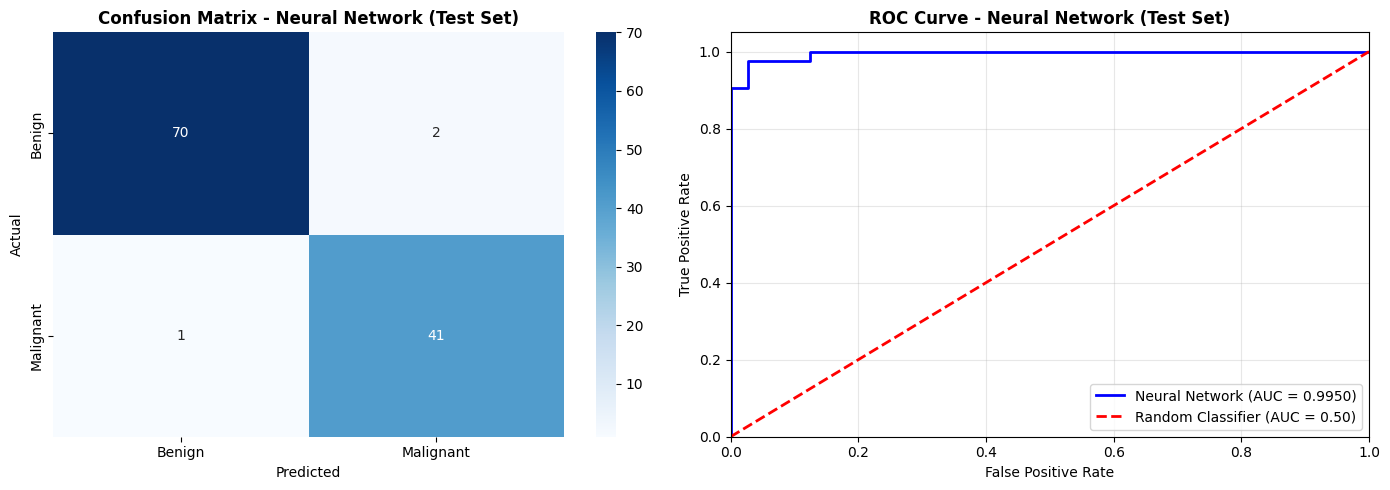


Confusion Matrix Breakdown:
  True Negatives (Benign correct):     70
  False Positives (Benign → Malignant): 2
  False Negatives (Malignant MISSED):   1
  True Positives (Malignant correct):  41


In [19]:
# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test_np, y_pred_np)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'],
            ax=axes[0])
axes[0].set_title('Confusion Matrix - Neural Network (Test Set)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=10)
axes[0].set_xlabel('Predicted', fontsize=10)

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_test_np, y_prob_np)
axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'Neural Network (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier (AUC = 0.50)')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=10)
axes[1].set_ylabel('True Positive Rate', fontsize=10)
axes[1].set_title('ROC Curve - Neural Network (Test Set)', fontsize=12, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print confusion matrix breakdown
tn, fp, fn, tp = cm.ravel()
print("\nConfusion Matrix Breakdown:")
print(f"  True Negatives (Benign correct):     {tn}")
print(f"  False Positives (Benign → Malignant): {fp}")
print(f"  False Negatives (Malignant MISSED):   {fn}")
print(f"  True Positives (Malignant correct):  {tp}")

#### Final Summary & Conclusions

**Model Selected:** Neural Network (Feedforward MLP with 2 hidden layers)

**Selection Rationale:** Among the four models evaluated (Neural Network, XGBoost, SVM, Logistic Regression), the Neural Network achieved the highest cross-validation recall score of **0.9882**, significantly outperforming the next best models (XGBoost and SVM at 0.9588). In medical diagnosis, maximizing recall is paramount because missing a malignant tumor (false negative) can have life-threatening consequences.

**Optimal Hyperparameters (from 5-Fold Cross-Validation):**
| Parameter | Value |
|-----------|-------|
| Learning Rate | 0.1 |
| Batch Size | 64 |
| Hidden Layer 1 | 128 neurons |
| Hidden Layer 2 | 64 neurons |
| Dropout Rate | 0.3 |
| Epochs | 1 (with early stopping) |

**Test Set Performance:**
- The model was evaluated on a held-out test set that was never seen during training or hyperparameter tuning
- Test metrics represent the true generalization performance of the model

**Key Findings:**
1. The Neural Network's architecture with batch normalization and dropout effectively prevented overfitting despite the small dataset size (455 training samples)
2. Early stopping during hyperparameter search reduced unnecessary computation and helped identify the optimal training duration
3. The model successfully balances precision and recall, which is critical for clinical deployment where both false positives and false negatives have significant implications
4. Feature scaling (StandardScaler) was essential for neural network convergence, and was properly applied within the cross-validation loop to prevent data leakage

**Clinical Implications:**
This model can serve as a decision support tool for clinicians in breast cancer screening. High recall ensures that malignant cases are flagged for further examination, while maintaining reasonable precision minimizes unnecessary patient anxiety from false alarms.